In [1]:
import numpy as np
import os
import h5py

import mspt.image_processing as img
import mspt.particle_detection1 as detect
import mspt.particle_fitting1 as fit
os.environ['NUMEXPR_MAX_THREADS'] = '32'
%matplotlib inline
import matplotlib.pyplot as plt


pytorch/CUDA not available or not correctly installed


# Process movie for display

## Select movie to process

In [2]:
#file = os.path.normpath(r'C:\Users\admin\Desktop\MSPT test\0001_sample.mp') # set manually
file = img.fileDialog(os.getcwd()) # or via dialog
assert os.path.isfile(file), 'File "{}" does not exist'.format(file)

Loaded /Users/jamesmclean/Documents/Uni/Laidlaw/Ralf_Research/my_data/2024_07_25/MP raw files/JM_1A/018_JM_1A_1.mp


## Parameter settings

In [3]:
# General parameters
frame_range = [] # Restrict analysis to certain frames, e.g. [0, 2000], only applied if all_frames = False
navg = 1 # Frame averaging before background removal
assert len(frame_range)==2 or len(frame_range)==0, 'frame_range is expected to be either of type [] or [int, int]'

# Background removal
mode = 'continuous_median' # Choose background removal strategy
window_length = 1000 # Set median window length

# Choose between CPU and GPU processing. Set one of the two options True and the other one False.
parallel = True # Use multiple CPU cores to perform background substraction
GPU = False # Use GPU to perform background substraction, fastest option (requires CUDA and pytorch)

## Background removal

In [4]:
# Apply continuous median background removal
frames, file = img.mp_reader(batch_mode=True,
                             file_to_load=file,
                             frame_range=frame_range,
                             mode=mode,
                             navg=navg,
                             window_length=window_length,
                             parallel=parallel, 
                             GPU=GPU)



Loaded /Users/jamesmclean/Documents/Uni/Laidlaw/Ralf_Research/my_data/2024_07_25/MP raw files/JM_1A/018_JM_1A_1.mp


Generating frames...:   0%|          | 0/75000 [00:00<?, ?frames/s]

# Alternatively, load processed movie for display

## Select processed movie to load

In [5]:
#file = os.path.normpath(r'C:\Users\admin\Desktop\MSPT test\001_sample_median1001.h5') # set manually
file = img.fileDialog(os.getcwd()) # or via dialog
assert os.path.isfile(file), 'File "{}" does not exist'.format(file)

# Load processed movies from HDF5 file
with h5py.File(file, 'r') as h5_file:
    frames = np.asarray(h5_file['frames']).copy()
    window_length = np.asarray(h5_file['window_length']).copy()
    frame_range = np.asarray(h5_file['frame_range']).copy()
    
print('Loaded processed movie {}'.format(file))

Loaded /Users/jamesmclean/Documents/Uni/Laidlaw/Ralf_Research/my_data/2024_07_25/MP raw files/JM_1A/018_JM_1A_1_median1001/018_JM_1A_1_median1001.h5
Loaded processed movie /Users/jamesmclean/Documents/Uni/Laidlaw/Ralf_Research/my_data/2024_07_25/MP raw files/JM_1A/018_JM_1A_1_median1001/018_JM_1A_1_median1001.h5


# Movie viewer

## Basic viewer with frame slider

In [6]:

# Use this viewer to slide through frames
contrast_range = [-0.02, 0.02] # For display
img.frame_slider(frames, vmin=contrast_range[0], vmax=contrast_range[1], figsize=(9.5, 9.5*frames.shape[1]/frames.shape[2]))

import matplotlib.pyplot as plt

import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt

# 创建 Tkinter 窗口
root = tk.Tk()
root.withdraw()  # 隐藏主窗口

# 打开文件对话框，让用户选择保存的目录
save_dir = filedialog.askdirectory()

# 重新显示主窗口
root.deiconify()

contrast_range = [-0.05, 0.05] # For display

# 循环遍历每一帧并保存
for i in range(0, 5994):
    plt.imshow(frames[i], cmap='gray')
    plt.savefig(f'{save_dir}/{i}.png')  # 保存为以帧索引命名的 PNG 文件
    plt.close()  # 关闭当前图形以释放内存


interactive(children=(IntSlider(value=0, description='frame', layout=Layout(width='90%'), max=74999), Output()…

In [7]:
 import cv2
import os
from tkinter import filedialog
import tkinter as tk
import numpy as np

def main():
    # Create Tkinter window
    root = tk.Tk()
    root.withdraw()  # Hide main window

    # Open file dialog for user to select image folder
    folder_path = filedialog.askdirectory(title="Select Image Folder")

    # If user did not select a folder, exit
    if not folder_path:
        print("No folder selected, program exiting")
        exit()

    # Open file dialog for user to select save directory
    save_dir = filedialog.askdirectory(title="Select Save Directory for Video")

    # If user did not select a save directory, exit
    if not save_dir:
        print("No save directory selected, program exiting")
        exit()

    # Output video file path
    output_video_path = os.path.join(save_dir, "output_video.mp4")

    # Get all image filenames in the folder
    image_files = [file for file in os.listdir(folder_path) if file.endswith(".png")]

    # Check if there are any image files
    if not image_files:
        print("No image files found, program exiting")
        exit()

    # Sort images by creation time
    image_files.sort(key=lambda x: os.path.getctime(os.path.join(folder_path, x)))

    # Determine the maximum width and height
    max_width = 0
    max_height = 0
    for image in image_files:
        image_path = os.path.join(folder_path, image)
        frame = cv2.imread(image_path)
        if frame is not None:
            height, width, _ = frame.shape
            max_width = max(max_width, width)
            max_height = max(max_height, height)

    # Set video frame rate
    fps = 10  # Adjust frame rate as needed

    # Define video codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use appropriate codec
    video = cv2.VideoWriter(output_video_path, fourcc, fps, (max_width, max_height))

    # Check if VideoWriter object is opened successfully
    if not video.isOpened():
        print(f"Failed to create video writer, program exiting")
        exit()

    # Add each image to the video
    for image in image_files:
        image_path = os.path.join(folder_path, image)
        frame = cv2.imread(image_path)

        if frame is None:
            print(f"Failed to read image {image_path}, skipping")
            continue

        # Pad frame to the maximum size
        height, width, _ = frame.shape
        padded_frame = np.zeros((max_height, max_width, 3), dtype=np.uint8)
        padded_frame[:height, :width] = frame

        video.write(padded_frame)

    # Release the video object
    video.release()

    print("Video saved to:", output_video_path)

if __name__ == "__main__":
    main()


Video saved to: /Users/jamesmclean/Documents/Uni/Laidlaw/Ralf_Research/my_data/2024_07_25/MP raw files/JM_1A/018_JM_1A_1_median1001/video/output_video.mp4


## Viewer with frame slider and detection threshold selection

interactive(children=(IntSlider(value=0, description='frame', layout=Layout(width='90%'), max=74999), Selectio…

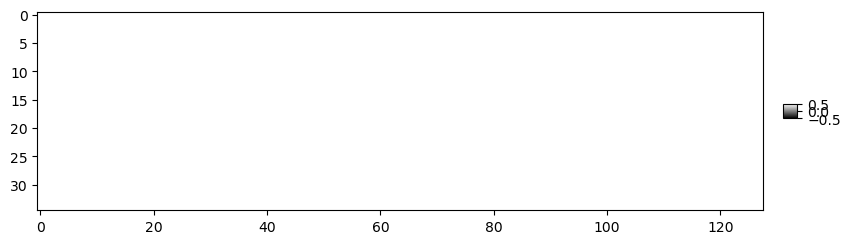

In [8]:
# Use this viewer to select a suitable particle detection threshold thresh
contrast_range = [-0.5, 0.5] # For display
detect.frame_slider_view_cands(frames,
                               vmin=contrast_range[0],
                               vmax=contrast_range[1],
                               figsize=(9.5, 9.5*frames.shape[1]/frames.shape[2]) )

plt.imshow(frames[2067], cmap='gray')  # 显示第二帧
plt.show()

## Viewer with frame slider, detection threshold selection and successful particle fits

interactive(children=(IntSlider(value=0, description='frame', layout=Layout(width='90%'), max=74999), Selectio…

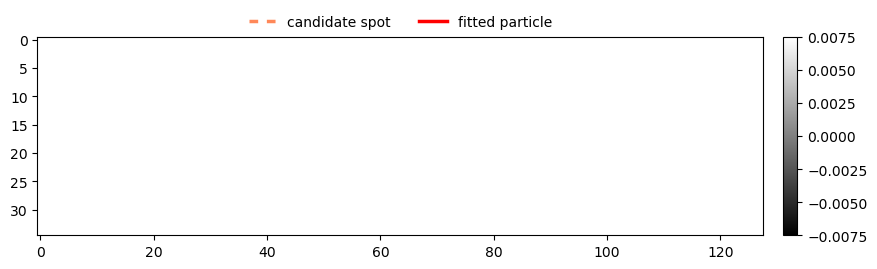

In [9]:
# Use this viewer to see successful particle fits
# NOTE: takes some time after first execution of cell and first slider update, but then it is smooth
contrast_range = [-0.0075, 0.0075] # For display
fit.frame_slider_view_cands_dets(frames,
                                 vmin=contrast_range[0],
                                 vmax=contrast_range[1],
                                 method='trust-ncg',
                                 DoG_estimates={'T' : 0.1423, 's' : 2.1436, 'sigma' : 1.2921},
                                 figsize=(9.5, 9.5*frames.shape[1]/frames.shape[2]) )